In [41]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids, CondensedNearestNeighbour, RandomUnderSampler
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pickle

import pathlib
from glob import glob
from data_loader import get_pdf_filepaths

In [42]:
from IPython import get_ipython
ip = get_ipython()
ip.InteractiveTB.set_mode(mode="Verbose")

In [43]:
def get_agg_dfs_filepaths(folder_path):
    absolute_folder_path = pathlib.Path(folder_path).resolve()
    #print(absolute_folder_path)
    pattern = str(absolute_folder_path / '**/aggregated.csv')
    #print(pattern)
    return glob(pattern)

In [48]:
def get_agg_dfs_filepaths_philosophy(folder_path):
    absolute_folder_path = pathlib.Path(folder_path).resolve()
    #print(absolute_folder_path)
    pattern = str(absolute_folder_path / 'philosophy/**/aggregated.csv')
    #print(pattern)
    return glob(pattern)

# 0. Create dataset from the csvs of all books

In [44]:
DATA_DIR_PATH = "../data/"
PDF_SOURCE_DIR_PATH = DATA_DIR_PATH + "pdf/"
PROCESSED_DATA_DIR_PATH = DATA_DIR_PATH + "processed/"

In [55]:
file_paths = get_agg_dfs_filepaths(PROCESSED_DATA_DIR_PATH)
file_paths

['/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/lycan_08/aggregated.csv',
 '/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/2015_Book_LinearAlgebra/aggregated.csv',
 '/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/2007BoolosComputability and Logic Fifth Edition/aggregated.csv',
 '/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/christensen_04/aggregated.csv',
 '/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/williamson_94/aggregated.csv',
 '/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/2014_Book_Microeconomics/aggregated.csv',
 '/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/jacobson_14/aggregated.csv',
 '/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/morris_07/aggregated.csv',
 '/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/moltmann_97/ag

In [52]:
file_paths_philo = get_agg_dfs_filepaths_philosophy(PROCESSED_DATA_DIR_PATH)
file_paths_philo

['/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/philosophy/lycan_08/aggregated.csv',
 '/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/philosophy/christensen_04/aggregated.csv',
 '/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/philosophy/williamson_94/aggregated.csv',
 '/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/philosophy/morris_07/aggregated.csv',
 '/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/philosophy/peregrin_17/aggregated.csv',
 '/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/philosophy/shapiro_97/aggregated.csv',
 '/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/philosophy/linnebo_18/aggregated.csv',
 '/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/philosophy/jenkins_08/aggregated.csv',
 '/Users/bertagrim/dev_projects/final_project/index_generator/data/

In [56]:
list_agg_dfs=[]
for path in file_paths:
    aggregated_df = pd.read_csv(path,index_col=0)
    list_agg_dfs.append(aggregated_df)
    
df = pd.concat(list_agg_dfs)

In [53]:
list_agg_dfs=[]
for path in file_paths_philo:
    aggregated_df = pd.read_csv(path,index_col=0)
    list_agg_dfs.append(aggregated_df)
    
df_s = pd.concat(list_agg_dfs)

In [54]:
df_s.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 372652 entries, 0 to 46618
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   candidate_keyword    372650 non-null  object 
 1   length               372652 non-null  int64  
 2   is_named_entity      372652 non-null  int64  
 3   is_named_author      372652 non-null  int64  
 4   is_in_toc            372652 non-null  int64  
 5   freq                 372652 non-null  float64
 6   is_in_index          372652 non-null  int64  
 7   tfidf                372652 non-null  float64
 8   importance           372652 non-null  float64
 9   position_in_context  372652 non-null  float64
 10  POS                  372652 non-null  object 
dtypes: float64(4), int64(5), object(2)
memory usage: 34.1+ MB


# 1. Feature engineering

In [57]:
df.reset_index(drop=True, inplace=True)

In [58]:
df_s.reset_index(drop=True, inplace=True)

In [59]:
df.groupby('POS').count()

,candidate_keyword,length,is_named_entity,is_named_author,is_in_toc,freq,is_in_index,tfidf,importance,position_in_context
POS,,,,,,,,,,
ADJ,19629,19637,19637,19637,19637,19637,19637,19637,19637,19637
ADP,769,769,769,769,769,769,769,769,769,769
ADV,7305,7305,7305,7305,7305,7305,7305,7305,7305,7305
AUX,282,282,282,282,282,282,282,282,282,282
CCONJ,98,98,98,98,98,98,98,98,98,98
CHUNK,749051,749051,749051,749051,749051,749051,749051,749051,749051,749051
DET,167,167,167,167,167,167,167,167,167,167
INTJ,251,251,251,251,251,251,251,251,251,251
NOUN,43999,43999,43999,43999,43999,43999,43999,43999,43999,43999


In [60]:
df.dropna(inplace=True)

In [61]:
df_s.dropna(inplace=True)

In [62]:
textbook_words=['whereas', 
                'conversely', 
                'result',
                'suggest',
                'contrast', 
                'comparison', 
                'view', 
                'likewise',
                'despite',
                'while',
                'subsequent',
                'subsequently',
                'overall',
                'summary',
                'sumarize',
                'first',
                'second', 
                'third',
                'firstly',
                'secondly', 
                'thirdly',
                'finally',
                'although',
                'thus',
                'again',
                'further',
                'then',
                'besides',
                'too',
                'similarly',
                'correspondingly',
                'regarding',
                'involved',
                'approach',
                'account',
                'theory',
                'method',
                'required',
                'process',
                'research',
                'role',
                'significant',
                'source',
                'variable',
                'issue',
                'function',
                'formula',
                'formulate',
                'phrase',
                'factor',
                'evidence',
                'derived',
                'derive',
                'establish',
                'concept',
                'available',
                'context',
                'assume',
                'assumption',
                'additionally',
                'additional',
                'analysis',
                'general',
                'certain',
                'certainly',
                'furthermore',
                'moreover',
                'nonetheless',
                'nevertheless',
                'bibliography',
                'prove',
                'part',
                'today', 
                'nowadays', 
                'actually', 
                'section', 
                'indeed', 
                'every', 
                'any', 
                'some',
                'instance',
                'example', 
                'therefore', 
                'definition',
                'define',
                'explain',
                'explanation',
                'introduction', 
                'conclusion',
                'conclude',
                'chapter', 
                'appendix', 
                'otherwise', 
                'thing',
                'concisely',
                'concise',
                'brief',
                'briefly',
                'rather', 
                'instead', 
                'like', 
                'since', 
                'given', 
                'case', 
                'hence', 
                'iff', 
                'see', 
                'beyond', 
                'below', 
                'above', 
                'postscript',
                'preface',
                'index', 
                'ensure', 
                'generally', 
                'anything', 
                'something',
                'everything',
                'other']

In [67]:
dict_tbw={}
for w in df.candidate_keyword:
    if w in textbook_words:
        dict_tbw[w]=1
    else:
        dict_tbw[w]=0

In [68]:
dict_tbw_s={}
for w in df_s.candidate_keyword:
    if w in textbook_words:
        dict_tbw_s[w]=1
    else:
        dict_tbw_s[w]=0

In [69]:
def is_a_tbw(x):
    if w in textbook_words:
        return 1
    else: 
        return 0

In [70]:
df['is_a_textbook_word']=df.candidate_keyword.apply(lambda x: dict_tbw[x])

In [71]:
df_s['is_a_textbook_word']=df_s.candidate_keyword.apply(lambda x: dict_tbw_s[x])

In [72]:
df_scaled = pd.get_dummies(df, columns=['POS'],
prefix = ['POS'])

In [73]:
df_s_scaled = pd.get_dummies(df_s, columns=['POS'],
prefix = ['POS'])

In [74]:
df_s_scaled.head()

,candidate_keyword,length,is_named_entity,is_named_author,is_in_toc,freq,is_in_index,tfidf,importance,position_in_context,...,POS_NOUN,POS_NUM,POS_PART,POS_PRON,POS_PROPN,POS_PUNCT,POS_SCONJ,POS_SYM,POS_VERB,POS_X
0,a-laying,8,0,0,0,0.000013,0,0.000000,0.662301,0.750000,...,1,0,0,0,0,0,0,0,0,0
1,a-laying police,15,0,0,0,0.000013,0,0.000000,0.662301,0.750000,...,0,0,0,0,0,0,0,0,0,0
2,aardvark,8,0,0,0,0.000013,0,0.000000,0.644323,1.000000,...,1,0,0,0,0,0,0,0,0,0
3,abandoned,9,0,0,0,0.000038,0,0.009811,0.449342,0.611827,...,0,0,0,0,0,0,0,0,1,0
4,abandoned commitment,20,0,0,0,0.000013,0,0.000000,0.392002,0.272727,...,0,0,0,0,0,0,0,0,0,0


In [75]:
df_scaled.drop(columns=['candidate_keyword'], inplace=True)

In [76]:
df_s_scaled.drop(columns=['candidate_keyword'], inplace=True)

In [77]:
df_scaled_columns = df_scaled.columns

In [78]:
df_s_scaled_columns = df_s_scaled.columns

In [79]:
scaler = MinMaxScaler() 

In [80]:
#not sure about this (do I need to concat or what?)
df_scaled = scaler.fit_transform(df_scaled)
df_scaled = pd.DataFrame(df_scaled, columns= df_scaled_columns)#not sure about this (do I need to concat or what?)

In [81]:
df_s_scaled = scaler.fit_transform(df_s_scaled)
df_s_scaled = pd.DataFrame(df_s_scaled, columns= df_s_scaled_columns)

In [82]:
df_scaled=df_scaled.rename(columns={"is_in_index": "target"})

In [83]:
df_s_scaled=df_s_scaled.rename(columns={"is_in_index": "target"})

In [84]:
df_s_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372650 entries, 0 to 372649
Data columns (total 28 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   length               372650 non-null  float64
 1   is_named_entity      372650 non-null  float64
 2   is_named_author      372650 non-null  float64
 3   is_in_toc            372650 non-null  float64
 4   freq                 372650 non-null  float64
 5   target               372650 non-null  float64
 6   tfidf                372650 non-null  float64
 7   importance           372650 non-null  float64
 8   position_in_context  372650 non-null  float64
 9   is_a_textbook_word   372650 non-null  float64
 10  POS_ADJ              372650 non-null  float64
 11  POS_ADP              372650 non-null  float64
 12  POS_ADV              372650 non-null  float64
 13  POS_AUX              372650 non-null  float64
 14  POS_CCONJ            372650 non-null  float64
 15  POS_CHUNK        

In [85]:
df_scaled.to_csv("../data/final_scaled.csv", encoding = 'utf-8')

In [86]:
df_s_scaled.to_csv("../data/final_scaled_small.csv", encoding = 'utf-8')

# 2. Quick EDA

In [26]:
path = '../data/final_scaled.csv'
df_scaled = pd.read_csv(path,index_col=0)
df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 856871 entries, 0 to 856870
Data columns (total 28 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   length               856871 non-null  float64
 1   is_named_entity      856871 non-null  float64
 2   is_named_author      856871 non-null  float64
 3   is_in_toc            856871 non-null  float64
 4   freq                 856871 non-null  float64
 5   target               856871 non-null  float64
 6   tfidf                856871 non-null  float64
 7   importance           856871 non-null  float64
 8   position_in_context  856871 non-null  float64
 9   is_a_textbook_word   856871 non-null  float64
 10  POS_ADJ              856871 non-null  float64
 11  POS_ADP              856871 non-null  float64
 12  POS_ADV              856871 non-null  float64
 13  POS_AUX              856871 non-null  float64
 14  POS_CCONJ            856871 non-null  float64
 15  POS_CHUNK        

In [27]:
path = '../data/final_scaled_small.csv'
df_s_scaled = pd.read_csv(path,index_col=0)
df_s_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 379489 entries, 0 to 379488
Data columns (total 25 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   length               379489 non-null  float64
 1   is_named_entity      379489 non-null  float64
 2   is_named_author      379489 non-null  float64
 3   is_in_toc            379489 non-null  float64
 4   freq                 379489 non-null  float64
 5   target               379489 non-null  float64
 6   tfidf                379489 non-null  float64
 7   importance           379489 non-null  float64
 8   position_in_context  379489 non-null  float64
 9   is_a_textbook_word   379489 non-null  float64
 10  POS_ADJ              379489 non-null  float64
 11  POS_ADP              379489 non-null  float64
 12  POS_ADV              379489 non-null  float64
 13  POS_AUX              379489 non-null  float64
 14  POS_CCONJ            379489 non-null  float64
 15  POS_CHUNK        

### Pairplot all columns

In [ ]:
g = sns.pairplot(df_scaled, y_vars= df_scaled.columns.values, x_vars="target")
g.fig.set_size_inches(7,14)

In [ ]:
pairplot=sns.pairplot(df_scaled, hue='target')

In [ ]:
pairplot

In [ ]:
pairplot.figure.savefig("..images/images/pairplot.png")

### Boxplots

In [ ]:
for column in df_scaled.drop(['target'], axis=1):
    plt.figure()
    df_scaled.boxplot([column])

### Correlation heatmap

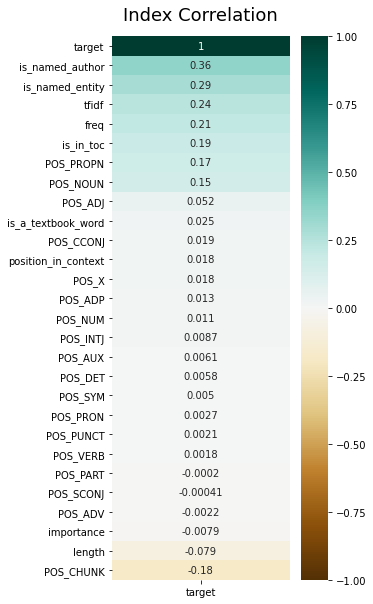

In [27]:
plt.figure(figsize=(4, 10))

heatmap = sns.heatmap(df_scaled.corr()[['target']].sort_values(by='target', ascending=False), 
                      vmin=-1, 
                      vmax=1,
                      annot=True,
                      cmap='BrBG')

heatmap.set_title('Index Correlation', fontdict={'fontsize':18}, pad=16);

plt.show()

In [30]:
heatmap.figure.savefig("../images/heatmap.png", bbox_inches="tight")

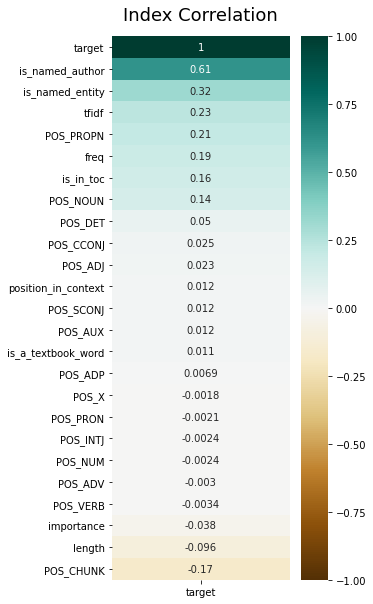

In [28]:
plt.figure(figsize=(4, 10))

heatmap_s = sns.heatmap(df_s_scaled.corr()[['target']].sort_values(by='target', ascending=False), 
                      vmin=-1, 
                      vmax=1,
                      annot=True,
                      cmap='BrBG')

heatmap_s.set_title('Index Correlation', fontdict={'fontsize':18}, pad=16);

plt.show()

In [29]:
heatmap_s.figure.savefig("../images/heatmap_s.png", bbox_inches="tight")

# 3. Train and test the models

In [87]:
X = df_scaled.drop('target', axis= 1)
y = df_scaled.target

In [88]:
X_s = df_s_scaled.drop('target', axis= 1)
y_s = df_s_scaled.target

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=42, stratify=y)

In [90]:
X_s_train, X_s_test, y_s_train, y_s_test = train_test_split(X_s, y_s, test_size=0.3,
                                                    random_state=42, stratify=y_s)

In [92]:
X_s_train[]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260855 entries, 316106 to 66976
Data columns (total 27 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   length               260855 non-null  float64
 1   is_named_entity      260855 non-null  float64
 2   is_named_author      260855 non-null  float64
 3   is_in_toc            260855 non-null  float64
 4   freq                 260855 non-null  float64
 5   tfidf                260855 non-null  float64
 6   importance           260855 non-null  float64
 7   position_in_context  260855 non-null  float64
 8   is_a_textbook_word   260855 non-null  float64
 9   POS_ADJ              260855 non-null  float64
 10  POS_ADP              260855 non-null  float64
 11  POS_ADV              260855 non-null  float64
 12  POS_AUX              260855 non-null  float64
 13  POS_CCONJ            260855 non-null  float64
 14  POS_CHUNK            260855 non-null  float64
 15  POS_DET      

## Oversampling

In [171]:
smote = SMOTE(random_state=42)

In [172]:
smote_s = SMOTE(random_state=42)

In [173]:
X_sm,y_sm=smote.fit_resample(X_train, y_train)

In [174]:
X_sm_s,y_sm_s=smote_s.fit_resample(X_s_train, y_s_train)

In [175]:
pickle.dump(X_sm, open('../models/X_sm.sav', 'wb'))
pickle.dump(y_sm, open('../models/y_sm.sav', 'wb'))

In [176]:
pickle.dump(X_sm_s, open('../models/X_sm_s.sav', 'wb'))
pickle.dump(y_sm_s, open('../models/y_sm_s.sav', 'wb'))

In [177]:
X_sm = pickle.load(open('../models/X_sm.sav', 'rb'))
y_sm = pickle.load(open('../models/y_sm.sav', 'rb'))

In [178]:
X_sm_s = pickle.load(open('../models/X_sm_s.sav', 'rb'))
y_sm_s = pickle.load(open('../models/y_sm_s.sav', 'rb'))

In [179]:
print('\nBefore OVER-sampling\n', y_train.value_counts())
print('\nAfter OVER-sampling\n', y_sm.value_counts())


Before OVER-sampling
 0.0    593265
1.0      6544
Name: target, dtype: int64

After OVER-sampling
 0.0    593265
1.0    593265
Name: target, dtype: int64


In [180]:
print('\nBefore OVER-sampling\n', y_s_train.value_counts())
print('\nAfter OVER-sampling\n', y_sm_s.value_counts())


Before OVER-sampling
 0.0    258184
1.0      2671
Name: target, dtype: int64

After OVER-sampling
 0.0    258184
1.0    258184
Name: target, dtype: int64


## Undersampling

In [ ]:
sampler = ClusterCentroids()
X_cc, y_cc = sampler.fit_resample(X_train, y_train)

In [40]:
sampler = ClusterCentroids()
X_cc_s, y_cc_s = sampler.fit_resample(X_s_train, y_s_train)

KeyboardInterrupt: 

In [ ]:
pickle.dump(X_cc, open('../models/X_cc.sav', 'wb'))
pickle.dump(y_cc, open('../models/y_cc.sav', 'wb'))

In [ ]:
pickle.dump(X_cc_s, open('../models/X_cc_s.sav', 'wb'))
pickle.dump(y_cc_s, open('../models/y_cc_s.sav', 'wb'))

In [ ]:
X_cc = pickle.load(open('../models/X_cc.sav', 'rb'))
y_cc = pickle.load(open('../models/y_cc.sav', 'rb'))

In [ ]:
X_cc_s = pickle.load(open('../models/X_cc_s.sav', 'rb'))
y_cc_s = pickle.load(open('../models/y_cc_s.sav', 'rb'))

In [ ]:
print('\nBefore UNDER-sampling\n', y_s_train.value_counts())
print('\nAfter UNDER-resampling\n', y_cc_s.value_counts())

## 3.1. Logistic regression

#### For big dataset

In [107]:
model_LR = LogisticRegression(random_state=42)

In [108]:
params_LR = {'penalty': ['l1', 'l2'],'C':[0.001,.009,0.01,.09,1,5,10,25]}

In [109]:
grid_search_cv_LR = GridSearchCV(model_LR, params_LR, 
                              scoring="accuracy",
                              n_jobs=-1, verbose=1, cv=10)

grid_search_cv_LR.fit(X_train, y_train)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


/Users/bertagrim/opt/anaconda3/envs/DataScience/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [       nan 0.98908986        nan 0.9901652         nan 0.99015687
        nan 0.99040861        nan 0.99044196        nan 0.99042028
        nan 0.99044196        nan 0.99043529]
  category=UserWarning

/Users/bertagrim/opt/anaconda3/envs/DataScience/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



GridSearchCV(cv=10, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [0.001, 0.009, 0.01, 0.09, 1, 5, 10, 25],
                         'penalty': ['l1', 'l2']},
             scoring='accuracy', verbose=1)

In [110]:
grid_search_cv_LR.best_params_

{'C': 1, 'penalty': 'l2'}

In [119]:
log_reg = LogisticRegression(random_state=42, penalty='l2', C=1, max_iter=200)

In [120]:
log_reg.fit(X_train, y_train)


LogisticRegression(C=1, max_iter=200, random_state=42)

In [121]:
pickle.dump(log_reg, open('../models/log_reg.sav', 'wb'))

In [122]:
log_reg = pickle.load(open('../models/log_reg.sav', 'rb'))

In [123]:
y_pred_LR = log_reg.predict(X_test)

#### For big dataset with SMOTE

In [107]:
model_LR_sm = LogisticRegression(random_state=42)

In [108]:
params_LR = {'penalty': ['l1', 'l2'],'C':[0.001,.009,0.01,.09,1,5,10,25]}

In [182]:
grid_search_cv_LR_sm = GridSearchCV(model_LR, params_LR, 
                              scoring="accuracy",
                              n_jobs=-1, verbose=1, cv=5)

grid_search_cv_LR_sm.fit(X_sm, y_sm)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


/Users/bertagrim/opt/anaconda3/envs/DataScience/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [       nan 0.79552308        nan 0.79586273        nan 0.7958543
        nan 0.79959377        nan 0.81740285        nan 0.82750879
        nan 0.83169579        nan 0.83230175]
  category=UserWarning

/Users/bertagrim/opt/anaconda3/envs/DataScience/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [0.001, 0.009, 0.01, 0.09, 1, 5, 10, 25],
                         'penalty': ['l1', 'l2']},
             scoring='accuracy', verbose=1)

In [183]:
grid_search_cv_LR_sm.best_params_

{'C': 25, 'penalty': 'l2'}

In [184]:
log_reg_sm = LogisticRegression(random_state=42, penalty='l2', C=25, max_iter=200)

In [185]:
log_reg_sm.fit(X_train, y_train)


/Users/bertagrim/opt/anaconda3/envs/DataScience/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



LogisticRegression(C=25, max_iter=200, random_state=42)

In [186]:
pickle.dump(log_reg_sm, open('../models/log_reg_sm.sav', 'wb'))

In [187]:
log_reg_sm = pickle.load(open('../models/log_reg_sm.sav', 'rb'))

In [189]:
y_pred_LR_sm = log_reg_sm.predict(X_test)

In [117]:
grid_search_cv_LR_s = GridSearchCV(model_LR, params_LR, 
                              scoring="accuracy",
                              n_jobs=-1, verbose=1, cv=10)

grid_search_cv_LR_s.fit(X_s, y_s)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


/Users/bertagrim/opt/anaconda3/envs/DataScience/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [       nan 0.9897606         nan 0.9915892         nan 0.99159687
        nan 0.99233674        nan 0.99232907        nan 0.99230991
        nan 0.99230224        nan 0.99228691]
  category=UserWarning



GridSearchCV(cv=10, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [0.001, 0.009, 0.01, 0.09, 1, 5, 10, 25],
                         'penalty': ['l1', 'l2']},
             scoring='accuracy', verbose=1)

In [118]:
grid_search_cv_LR_s_.best_params_

{'C': 0.09, 'penalty': 'l2'}

In [135]:
log_reg_s = LogisticRegression(random_state=42, penalty='l2', C=0.09, max_iter=200)

In [136]:
log_reg_s.fit(X_s, y_s)

LogisticRegression(C=0.09, max_iter=200, random_state=42)

In [137]:
pickle.dump(log_reg_s, open('../models/log_reg_s.sav', 'wb'))

In [138]:
log_reg_s = pickle.load(open('../models/log_reg_s.sav', 'rb'))

In [139]:
y_pred_LR_s = log_reg_s.predict(X_s_test)

#### For small dataset with SMOTE

In [ ]:
grid_search_cv_LR_s_sm = GridSearchCV(model_LR, params_LR, 
                              scoring="accuracy",
                              n_jobs=-1, verbose=1, cv=5)

grid_search_cv_LR_s_sm.fit(X_sm_s, y_sm_s)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [118]:
grid_search_cv_LR_s_sm.best_params_

{'C': 0.09, 'penalty': 'l2'}

In [135]:
log_reg_s_sm = LogisticRegression(random_state=42, penalty='l2', C=0.09, max_iter=200)

In [136]:
log_reg_s_sm.fit(X_sm_s, y_sm_s)

LogisticRegression(C=0.09, max_iter=200, random_state=42)

In [137]:
pickle.dump(log_reg_s_sm, open('../models/log_reg_s_sm.sav', 'wb'))

In [138]:
log_reg_s_sm = pickle.load(open('../models/log_reg_s_sm.sav', 'rb'))

In [139]:
y_pred_LR_s_sm = log_reg_s_sm.predict(X_sm_s)

#### For small dataset

#### Metrics

In [140]:
print('METRICS FOR LOG REG (big):')
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_LR)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_LR)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_LR)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_LR)))
print()
print('METRICS FOR LOG REG (small):')
print('Accuracy Score : ' + str(accuracy_score(y_s_test,y_pred_LR_s)))
print('Precision Score : ' + str(precision_score(y_s_test,y_pred_LR_s)))
print('Recall Score : ' + str(recall_score(y_s_test,y_pred_LR_s)))
print('F1 Score : ' + str(f1_score(y_s_test,y_pred_LR_s)))

METRICS FOR LOG REG (big):
Accuracy Score : 0.9902397087084049
Precision Score : 0.6792223572296476
Recall Score : 0.199358059914408
F1 Score : 0.30824372759856633

METRICS FOR LOG REG (small):
Accuracy Score : 0.9925130819804105
Precision Score : 0.86810551558753
Recall Score : 0.31643356643356646
F1 Score : 0.4638052530429212


In [192]:
print('METRICS FOR LOG REG with SMOTE (big):')
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_LR_sm)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_LR_sm)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_LR_sm)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_LR_sm)))

METRICS FOR LOG REG with SMOTE (big):
Accuracy Score : 0.9901930273630486
Precision Score : 0.6686531585220501
Recall Score : 0.20007132667617689
F1 Score : 0.3079879220422729


In [ ]:
print()
print('METRICS FOR LOG REG with SMOTE (small):')
print('Accuracy Score : ' + str(accuracy_score(y_s_test,y_pred_LR_s_sm)))
print('Precision Score : ' + str(precision_score(y_s_test,y_pred_LR_s_sm)))
print('Recall Score : ' + str(recall_score(y_s_test,y_pred_LR_s_sm)))
print('F1 Score : ' + str(f1_score(y_s_test,y_pred_LR_s_sm)))

In [141]:
print('Confusion Matrix (big): \n' + str(confusion_matrix(y_test,y_pred_LR)))
print('Confusion Matrix (small): \n' + str(confusion_matrix(y_s_test,y_pred_LR_s)))

Confusion Matrix (big): 
[[253994    264]
 [  2245    559]]
Confusion Matrix (small): 
[[110596     55]
 [   782    362]]


In [ ]:
print('Confusion Matrix with SMOTE (big): \n' + str(confusion_matrix(y_test,y_pred_LR_sm)))
print('Confusion Matrix with SMOTE (small): \n' + str(confusion_matrix(y_s_test,y_pred_LR_s_sm)))

#### Explainability

In [ ]:
#another way of doing logistic regression with cv (I think the same thing does not exist for random forest):
log_reg_cv = LogisticRegressionCV(random_state=42)

log_reg_cv.fit(X_train, y_train)

y_pred_logcv = log_reg_cv.predict(X_test)

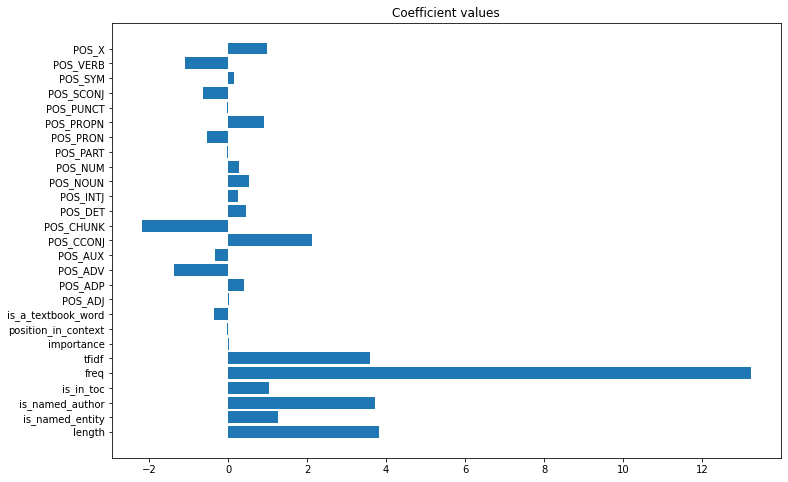

In [163]:
plt.figure(figsize=(12,8))
plt.barh(X.columns,log_reg.coef_[0]) #potser log_ref_cv?
plt.title("Coefficient values")
plt.show()

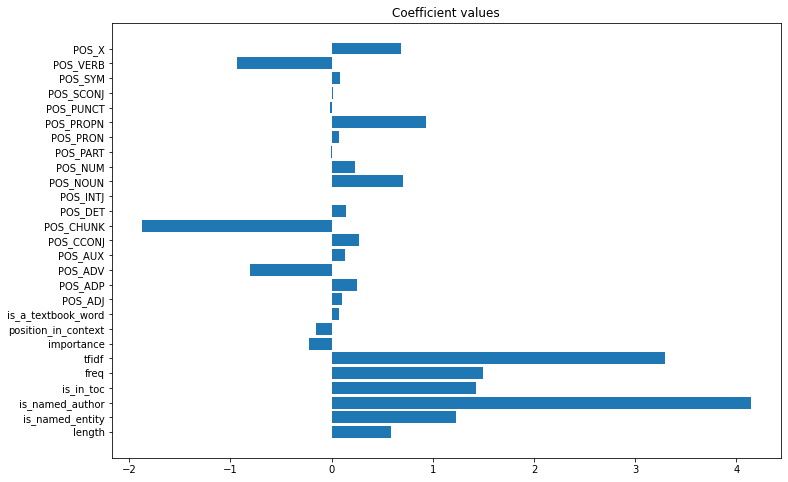

In [164]:
plt.figure(figsize=(12,8))
plt.barh(X_s.columns,log_reg_s.coef_[0]) #potser log_ref_cv?
plt.title("Coefficient values")
plt.show()

In [ ]:
y_proba = log_reg.predict_proba(X_test)#check what this is

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(np.sort(y_proba[:,0]))
plt.axhline(0.5, c='r')
plt.show()

### 3.2. Random forest

### Big

In [ ]:
params_RF = {'n_estimators': [50, 100, 200],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [50, 100],
               #'min_samples_split': [2, 5, 10],
               #'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

In [ ]:
grid_search_cv_RF = GridSearchCV(model_RF, params_RF, 
                              scoring="f1",
                              n_jobs=-1, verbose=1, cv=5)

grid_search_cv_RF.fit(X_train, y_train)

In [ ]:
grid_search_cv_RF.best_params_

In [146]:
rand_forest = RandomForestClassifier(random_state=42)

In [147]:
rand_forest.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [148]:
pickle.dump(rand_forest, open('../models/rand_forest.sav', 'wb'))

In [149]:
rand_forest = pickle.load(open('../models/rand_forest.sav', 'rb'))

In [150]:
y_pred_RF = rand_forest.predict(X_test)

### Random Forest with smote (big)

In [193]:
rand_forest_sm = RandomForestClassifier(random_state=42)

In [194]:
rand_forest_sm.fit(X_sm, y_sm)

RandomForestClassifier(random_state=42)

In [195]:
pickle.dump(rand_forest_sm, open('../models/rand_forest_sm.sav', 'wb'))

In [196]:
rand_forest_sm = pickle.load(open('../models/rand_forest_sm.sav', 'rb'))

In [197]:
y_pred_RF_sm = rand_forest_sm.predict(X_test)

### Small

In [151]:
params_RF = {'n_estimators': [50, 100, 200],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [50, 100],
               #'min_samples_split': [2, 5, 10],
               #'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

In [ ]:
model_RF = RandomForestClassifier(random_state=42)

In [152]:
grid_search_cv_RF_s = GridSearchCV(model_RF, params_RF, 
                              scoring="f1",
                              n_jobs=-1, verbose=1, cv=5)

grid_search_cv_RF_s.fit(X_s_train, y_s_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits



KeyboardInterrupt



In [ ]:
grid_search_cv_RF_s.best_params_

In [153]:
rand_forest_s = RandomForestClassifier(random_state=42)

In [154]:
rand_forest_s.fit(X_s_train, y_s_train)

RandomForestClassifier(random_state=42)

In [155]:
pickle.dump(rand_forest_s, open('../models/rand_forest_s.sav', 'wb'))

In [156]:
rand_forest_s = pickle.load(open('../models/rand_forest_s.sav', 'rb'))

In [157]:
y_pred_RF_s = rand_forest_s.predict(X_s_test)

### Small with SMOTE

In [198]:
rand_forest_s_sm = RandomForestClassifier(random_state=42)

In [199]:
rand_forest_s_sm.fit(X_sm_s, y_sm_s)

RandomForestClassifier(random_state=42)

In [200]:
pickle.dump(rand_forest_s_sm, open('../models/rand_forest_s_sm.sav', 'wb'))

In [201]:
rand_forest_s_sm = pickle.load(open('../models/rand_forest_s_sm.sav', 'rb'))

In [202]:
y_pred_RF_s_sm = rand_forest_s_sm.predict(X_s_test)

#### Metrics

In [158]:
print('Random forest (big):')
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_RF)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_RF)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_RF)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_RF)))
print()
print('Random forest (small):')
print('Accuracy Score : ' + str(accuracy_score(y_s_test,y_pred_RF_s)))
print('Precision Score : ' + str(precision_score(y_s_test,y_pred_RF_s)))
print('Recall Score : ' + str(recall_score(y_s_test,y_pred_RF_s)))
print('F1 Score : ' + str(f1_score(y_s_test,y_pred_RF_s)))

Random forest (big):
Accuracy Score : 0.9905664781258996
Precision Score : 0.710789766407119
Recall Score : 0.22788873038516405
F1 Score : 0.34512557385903325

Random forest (small):
Accuracy Score : 0.9926293662507267
Precision Score : 0.810077519379845
Recall Score : 0.36538461538461536
F1 Score : 0.5036144578313253


In [203]:
print('Random forest with SMOTE (big):')
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_RF_sm)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_RF_sm)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_RF_sm)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_RF_sm)))
print()
print('Random forest with SMOTE (small):')
print('Accuracy Score : ' + str(accuracy_score(y_s_test,y_pred_RF_s_sm)))
print('Precision Score : ' + str(precision_score(y_s_test,y_pred_RF_s_sm)))
print('Recall Score : ' + str(recall_score(y_s_test,y_pred_RF_s_sm)))
print('F1 Score : ' + str(f1_score(y_s_test,y_pred_RF_s_sm)))

Random forest with SMOTE (big):
Accuracy Score : 0.9774723607534369
Precision Score : 0.24102653025836657
Recall Score : 0.4957203994293866
F1 Score : 0.3243495508108739

Random forest with SMOTE (small):
Accuracy Score : 0.9831656156357619
Precision Score : 0.3185840707964602
Recall Score : 0.5664335664335665
F1 Score : 0.40780365009439895


In [159]:
print('Confusion Matrix (big): \n' + str(confusion_matrix(y_test,y_pred_RF)))
print('Confusion Matrix (small): \n' + str(confusion_matrix(y_s_test,y_pred_RF_s)))

Confusion Matrix (big): 
[[253998    260]
 [  2165    639]]
Confusion Matrix (small): 
[[110553     98]
 [   726    418]]


#### Explainability

In [165]:
importance = rand_forest.feature_importances_

list_of_importance=zip(X.columns.tolist(), importance.tolist())

print(list(list_of_importance))

[('length', 0.0808654050221253), ('is_named_entity', 0.04373034609175702), ('is_named_author', 0.09474175918115002), ('is_in_toc', 0.017515542142916278), ('freq', 0.18468346741927696), ('tfidf', 0.11878224611479467), ('importance', 0.23095261935252037), ('position_in_context', 0.19267036583116856), ('is_a_textbook_word', 0.002001139957727225), ('POS_ADJ', 0.0030639475681933383), ('POS_ADP', 0.0005766296400120938), ('POS_ADV', 0.0014118600727802948), ('POS_AUX', 0.0002349645004500371), ('POS_CCONJ', 0.00048437363733495274), ('POS_CHUNK', 0.005226055017861377), ('POS_DET', 0.00027999769951930417), ('POS_INTJ', 0.00019386566455506122), ('POS_NOUN', 0.008226777442087373), ('POS_NUM', 0.0006363634127291801), ('POS_PART', 3.2736778047116935e-09), ('POS_PRON', 0.0001384447763117179), ('POS_PROPN', 0.009688666875876979), ('POS_PUNCT', 6.68833183684519e-05), ('POS_SCONJ', 9.796370720527263e-05), ('POS_SYM', 4.420065399760329e-05), ('POS_VERB', 0.00327574755621989), ('POS_X', 0.00041036406938304

In [208]:
importance_sm = rand_forest_sm.feature_importances_

list_of_importance_sm=zip(X_sm.columns.tolist(), importance_sm.tolist())

print(list(list_of_importance_sm))

[('length', 0.14293241085967592), ('is_named_entity', 0.037498507865834016), ('is_named_author', 0.021964322289853434), ('is_in_toc', 0.005381563606286845), ('freq', 0.3682960009125955), ('tfidf', 0.10426430163740315), ('importance', 0.06663307494504839), ('position_in_context', 0.0877376605599764), ('is_a_textbook_word', 0.0007519239844294229), ('POS_ADJ', 0.0034251059701786678), ('POS_ADP', 0.000300273120922381), ('POS_ADV', 0.003623418173374761), ('POS_AUX', 0.00010063059723647133), ('POS_CCONJ', 0.00015775080299029498), ('POS_CHUNK', 0.09399474122663974), ('POS_DET', 0.0001334219574349603), ('POS_INTJ', 0.00016158867422632885), ('POS_NOUN', 0.03417602563168463), ('POS_NUM', 0.00017758421740735433), ('POS_PART', 4.6681800430795196e-08), ('POS_PRON', 0.00016164117753917227), ('POS_PROPN', 0.018101510597467715), ('POS_PUNCT', 1.5388088139410666e-05), ('POS_SCONJ', 0.00022615778359647172), ('POS_SYM', 6.997537142007054e-06), ('POS_VERB', 0.009591391508003207), ('POS_X', 0.0001865595931

In [167]:
importance_s = rand_forest_s.feature_importances_

list_of_importance_s=zip(X_s.columns.tolist(), importance_s.tolist())

print(list(list_of_importance_s))

[('length', 0.08370992624573023), ('is_named_entity', 0.04987399562853203), ('is_named_author', 0.18378448019516164), ('is_in_toc', 0.012636717307963561), ('freq', 0.14459397700259854), ('tfidf', 0.11574415976837889), ('importance', 0.19803243056587963), ('position_in_context', 0.16872828087497094), ('is_a_textbook_word', 0.002168178470303392), ('POS_ADJ', 0.0033253045552102), ('POS_ADP', 0.0005920049546194177), ('POS_ADV', 0.0016220158123774148), ('POS_AUX', 0.00047769876862856567), ('POS_CCONJ', 0.00028296727225317445), ('POS_CHUNK', 0.004976167677505434), ('POS_DET', 0.0003550806545492421), ('POS_INTJ', 7.242826322037024e-05), ('POS_NOUN', 0.00900770518625953), ('POS_NUM', 0.0005158620472411164), ('POS_PART', 1.0036655494670628e-07), ('POS_PRON', 0.0002861899587838813), ('POS_PROPN', 0.01483795675938663), ('POS_PUNCT', 0.00021768071012364778), ('POS_SCONJ', 0.0002661367019507186), ('POS_SYM', 0.00011737775410472614), ('POS_VERB', 0.003004540819866405), ('POS_X', 0.000770635677845732

In [205]:
importance_s_sm = rand_forest_s_sm.feature_importances_

list_of_importance_s_sm=zip(X_sm.columns.tolist(), importance_s_sm.tolist())

print(list(list_of_importance_s_sm))

[('length', 0.13940020680399878), ('is_named_entity', 0.046968394413055344), ('is_named_author', 0.04384513336519245), ('is_in_toc', 0.004271537601972056), ('freq', 0.3507933778673471), ('tfidf', 0.10570981370628982), ('importance', 0.06038269405655947), ('position_in_context', 0.0742598447385515), ('is_a_textbook_word', 0.0009127985513064876), ('POS_ADJ', 0.003652202432943447), ('POS_ADP', 0.0003272068935715681), ('POS_ADV', 0.003063590230965707), ('POS_AUX', 0.0001509258634654333), ('POS_CCONJ', 0.0001247652224052055), ('POS_CHUNK', 0.10207199115649714), ('POS_DET', 0.00018358673863928265), ('POS_INTJ', 6.122821727824144e-05), ('POS_NOUN', 0.03021611966845911), ('POS_NUM', 0.00017735004322485127), ('POS_PART', 1.2120740005995298e-06), ('POS_PRON', 0.00012871977298217971), ('POS_PROPN', 0.022306668808334026), ('POS_PUNCT', 2.1558892244737657e-05), ('POS_SCONJ', 0.00026479940122219373), ('POS_SYM', 7.243134930269352e-06), ('POS_VERB', 0.010231509758871622), ('POS_X', 0.0004655205856914

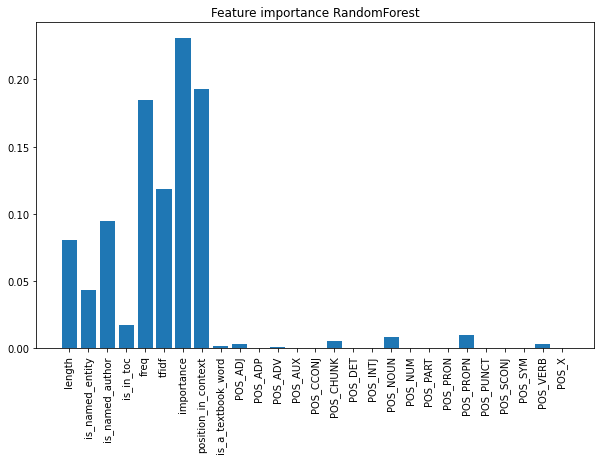

In [166]:
plt.figure(figsize=(10, 6))

arr = [x for x in range(len(importance))]
labels = X.columns.tolist()
plt.bar(arr, importance)
plt.title('Feature importance RandomForest')
plt.xticks(arr, labels, rotation=90)
plt.show()
#sort it and save this one!

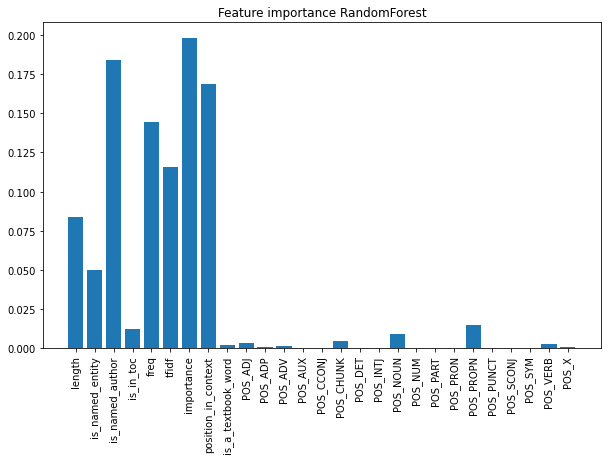

In [170]:
plt.figure(figsize=(10, 6))

arr = [x for x in range(len(importance_s))]
labels = X_s.columns.tolist()
plt.bar(arr, importance_s)
plt.title('Feature importance RandomForest')
plt.xticks(arr, labels, rotation=90)
plt.show()
#sort it

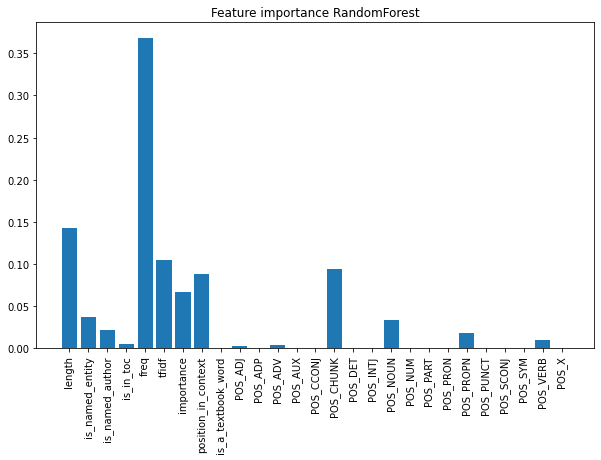

In [209]:
plt.figure(figsize=(10, 6))

arr = [x for x in range(len(importance_sm))]
labels = X_sm.columns.tolist()
plt.bar(arr, importance_sm)
plt.title('Feature importance RandomForest')
plt.xticks(arr, labels, rotation=90)
plt.show()
#sort it

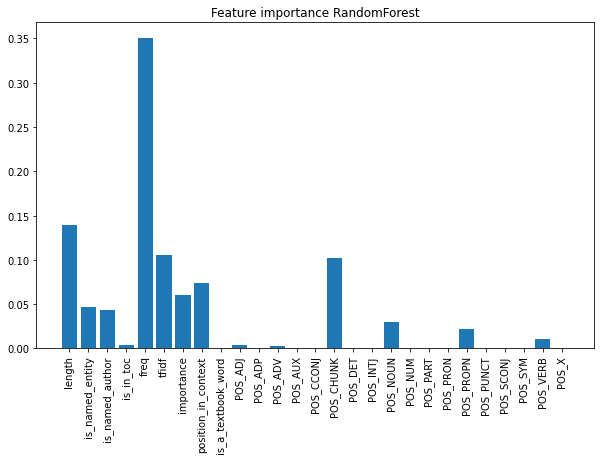

In [210]:
plt.figure(figsize=(10, 6))

arr = [x for x in range(len(importance_s_sm))]
labels = X_sm_s.columns.tolist()
plt.bar(arr, importance_s_sm)
plt.title('Feature importance RandomForest')
plt.xticks(arr, labels, rotation=90)
plt.show()
#sort it

# SVM with previous PCA

In [ ]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_cc, 
                                                    test_size=0.3, 
                                                    random_state=42)

In [ ]:
svc = SVC()

In [ ]:
svc.fit(X_train_pca,y_train_pca)

In [ ]:
y_pca_svc = gb_clf.predict(X_test)

In [ ]:
print('Accuracy Score : ' + str(accuracy_score(y_test_pca,y_sm_gbcl)))
print('Precision Score : ' + str(precision_score(y_test_pca,y_sm_gbcl)))
print('Recall Score : ' + str(recall_score(y_test_pca,y_sm_gbcl)))
print('F1 Score : ' + str(f1_score(y_test_pca,y_sm_gbcl)))

In [ ]:
#todo: 
#think well about the metrics: what do I prefer
#check ways to reduce the data set
#keep track of the metrics and do some visualization on the variation betwen different models

In [ ]:
#things to try:
#try with only non-technical books -- see if I get better metrics
#try SVM (with fewer samples)
#reduce dataset with PCA